In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import requests
import os
import time
import numpy as np
import io
from PIL import Image
import random

from concurrent.futures import ThreadPoolExecutor, as_completed

from tensorflow.keras.models import load_model

PROXY = "http://209.205.212.34:1203"

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--proxy-server=%s' % PROXY)
# chrome_options.add_argument('headless')
driver = webdriver.Chrome('../../chromedriver', chrome_options=chrome_options)

car_model_link = 'https://www.netcarshow.com/audi/2020-tt_rs_roadster/'
driver.get(car_model_link)


/Users/Arshak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: use options instead of chrome_options


In [2]:
model = load_model('noise_classifier.h5')

In [3]:
http_proxy  = "http://209.205.212.34:1203"
https_proxy = "https://209.205.212.34:1203"
ftp_proxy   = "ftp://209.205.212.34:1203"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
              "ftp"   : ftp_proxy
            }

In [4]:
def modify_link(link):
    if '[' in link and ']' in link:
        return link[: link.find('[')] + link[link.find('[') + 1: link.find(']')] + '-Version' + link[link.find(']') + 1:]
    return link

In [5]:
make_name = 'Audi'
while True:
    driver.get(car_model_link)
    try:
        name = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='cc']/article/div[1]/h1/strong"))).text[len(make_name) + 1:]
        print('Name is found')
        break
    except:
        print('Wait Timeout for name')
        print(car_model_link)
        continue
print(name)

all_images = driver.find_elements_by_xpath("//*[contains(@id, 'thpg')]/div")

links_to_image = []
for n, image in enumerate(all_images):
    try:
        link_to_image = image.find_element_by_xpath(f".//*[contains(text(), '1024')]").get_attribute('href')
        links_to_image.append(link_to_image)
    except:
        print('Element has no 1024 resolution option:', f'{n} picture')
        continue


image_links = []
for link_to_image in links_to_image:
    year = '2020' if '2020' in name else '2021'
    image_links.append(modify_link('https://www.netcarshow.com/' + '_'.join(make_name.split(' ')) + '-' + '_'.join(name.split(' ')[:-1]) + '-' + year + '-1024-' + link_to_image[-6:-4] + '.jpg'))
print('Number of images:', len(image_links))
print(image_links)

Name is found
TT RS Roadster (2020)
Element has no 1024 resolution option: 22 picture
Number of images: 22
['https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-01.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-02.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0d.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-03.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-04.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-05.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-06.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-07.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-08.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-09.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0a.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0b.jpg', 'https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0c.jpg', 'https://www.netcarsh

In [10]:
html = requests.get(image_links[0], proxies=proxyDict, stream=True)

0


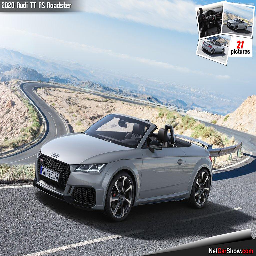

In [11]:
image = np.array(Image.open(io.BytesIO(html.content)).resize((256, 256)))
image = np.expand_dims(image, 0)
pred = model.predict_classes(image)[0][0]
print(pred)
Image.open(io.BytesIO(html.content)).resize((256, 256))

In [12]:
driver.close()
def download_file(url, n):
    for _ in range(5):
        try:
            time.sleep(3)
            html = requests.get(url, proxies=proxyDict, stream=True)
            image = np.array(Image.open(io.BytesIO(html.content)).resize((256, 256)))
            image = np.expand_dims(image, 0)
            pred = model.predict_classes(image)[0][0]
            if pred == 1:
                print('Request got noisy image')
                continue
            print(f'Found data for {n} picture:', url)
            break
        except:
            pass
    else: 
        print('Could not load an image' + '-' * 10)
        return (None, n)
    return (html.content, n) if  model.predict_classes(np.expand_dims(np.array(Image.open(io.BytesIO(html.content)).resize((256, 256))), 0))[0][0] else (None, n)

processes = []
with ThreadPoolExecutor(max_workers=(10)) as executor:
    for n, url in enumerate(image_links):
#         n_user_agent = random.randint(0, len(user_agents) - 1)
        processes.append(executor.submit(download_file, url, n))
final_results = []
for task in as_completed(processes):
    try:
        final_results.append(task.result())
    except:
        print('Did not get some image')
        continue

for picture, n in final_results:
    if picture == None:
        print(f'Image number {n} was not included because w')
        continue
    with open(os.path.join('test', f'{n}.jpg'), 'wb') as handler:
        handler.write(picture)

Found data for 2 picture: https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0d.jpg
Found data for 8 picture: https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-08.jpg
Request got noisy image
Found data for 1 picture: https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-02.jpg
Found data for 3 picture: https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-03.jpg
Found data for 10 picture: https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0a.jpg
Found data for 11 picture: https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0b.jpg
Request got noisy image
Request got noisy image
Request got noisy image
Request got noisy image
Could not load an image
Request got noisy image
Request got noisy image
Request got noisy image
Could not load an image
Found data for 14 picture: https://www.netcarshow.com/Audi-TT_RS_Roadster-2020-1024-0e.jpg
Could not load an image
Request got noisy image
Request got noisy image
Request got noisy image
Found data for 17 picture: http

In [9]:
image_links[0]

'https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-01.jpg'

0


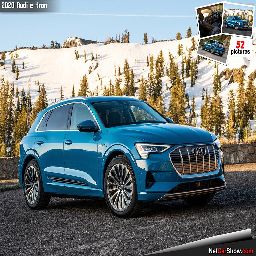

Request got noisy image
Could not load an image
Found data for 29 picture: https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-1c.jpg
Found data for 27 picture: https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-1a.jpg
Request got noisy image
Found data for 37 picture: https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-24.jpg
Request got noisy image
Request got noisy image
Found data for 39 picture: https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-26.jpg
Request got noisy image
Found data for 36 picture: https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-23.jpg
Found data for 30 picture: https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-1d.jpg
Request got noisy image
Found data for 28 picture: https://www.netcarshow.com/Audi-e-tron_US-Version-2020-1024-1b.jpg
Request got noisy image
Request got noisy image


In [10]:
print(pred)
Image.open(io.BytesIO(html.content)).resize((256, 256))

In [85]:
len(all_images)

32

In [20]:
options = webdriver.ChromeOptions()
options.add_argument('--proxy-server=%s' % PROXY)
options.add_argument("start-maximized")
options.add_argument("--headless")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
driver = webdriver.Chrome('../../chromedriver', chrome_options=options)

car_model_link = 'https://www.netcarshow.com/audi/2020-a6_allroad_quattro/'
make_name = 'Audi'
while True:
    driver.get(car_model_link)
    try:
        name = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='cc']/article/div[1]/h1/strong"))).text[len(make_name) + 1:]
        print('Name is found')
        break
    except:
        print('Wait Timeout for name')
        print(car_model_link)
        continue
print(name)

all_images = driver.find_elements_by_xpath("//*[contains(@id, 'thpg')]/div")
print('All_images:', len(all_images))

links_to_image = []
for n, image in enumerate(all_images):
    try:
        link_to_image = image.find_element_by_xpath(f".//*[contains(text(), '1024')]").get_attribute('href')
        links_to_image.append(link_to_image)
    except:
        print('Element has no 1024 resolution option:', f'{n} picture')
        continue

print(links_to_image)
image_links = []
for link_to_image in links_to_image:
    year = '2020' if '2020' in name else '2021'
    image_links.append('https://www.netcarshow.com/' + '_'.join(make_name.split(' ')) + '-' + '_'.join(name.split(' ')[:-1]) + '-' + year + '-1024-' + link_to_image[-6:-4] + '.jpg')
print('Number of images:', len(image_links))
print(image_links)



def download_file(url, n):
    
    for _ in range(20):
        try:
            html = requests.get(url, proxies=proxyDict, stream=True)
            image = np.array(Image.open(io.BytesIO(html.content)).resize((256, 256)))
            image = np.expand_dims(image, 0)
            pred = model.predict_classes(image)[0][0]
            if pred == 1:
                print('Request got noisy image')
                continue
            print(f'Found data for {n} picture:', url)
            break
        except:
            pass
    return (html.content, n)

processes = []
with ThreadPoolExecutor(max_workers=(10)) as executor:
    for n, url in enumerate(image_links):
#         n_user_agent = random.randint(0, len(user_agents) - 1)
        processes.append(executor.submit(download_file, url, n))
final_results = []
for task in as_completed(processes):
    try:
        final_results.append(task.result())
    except:
        print('Did not get some image')
        continue

for picture, n in final_results:
    with open(os.path.join('test', f'{n}.jpg'), 'wb') as handler:
        handler.write(picture)

# driver.close()

/Users/Arshak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys


Request got noisy image
Request got noisy image
Request got noisy image
Request got noisy image
Request got noisy image


KeyboardInterrupt: 

In [53]:
with open('../user-agents.txt', 'r') as f:
    user_agents = f.read().split('\n')
print(len(user_agents))

1001


In [ ]:
'https://www.netcarshow.com/audi/2020-e-tron_us-version/'

In [63]:
PROXY = "http://209.205.212.34:1203"

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--proxy-server=%s' % PROXY)
chrome_options.add_argument('headless')
driver = webdriver.Chrome('../../chromedriver', chrome_options=chrome_options)

car_model_link = 'https://www.netcarshow.com/audi/2020-e-tron_us-version/'
while True:
    driver.get(car_model_link)
    try:
        name = WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.XPATH, "//*[@id='cc']/article/div[1]/h1/strong"))).text[len(make_name) + 1:]
        print('Name of car model is found')
        break
    except:
        print('Wait Timeout for the name of car model')
        print(car_model_link)
        continue
print(name)
dir_name_model = os.path.join(dir_make, name)
if not os.path.exists(dir_name_model):
    os.mkdir(dir_name_model)

all_images = driver.find_elements_by_xpath("//*[contains(@id, 'thpg')]/div")

links_to_image = []
for n, image in enumerate(all_images):
    try:
        link_to_image = image.find_element_by_xpath(f".//*[contains(text(), '1024')]").get_attribute('href')
        links_to_image.append(link_to_image)
    except:
        print('Element has no 1024 resolution option:', f'picture number {n}')
        continue

image_links = []
for link_to_image in links_to_image:
    year = '2020' if '2020' in name else '2021'
    image_links.append('https://www.netcarshow.com/' + '_'.join(make_name.split(' ')) + '-' + '_'.join(name.split(' ')[:-1]) + '-' + year + '-1024-' + link_to_image[-6:-4] + '.jpg')
print('Number of images:', len(image_links))



def download_file(url, n):
    for _ in range(30):
        try:
            html = requests.get(url, proxies=proxyDict, stream=True)
            image = np.array(Image.open(io.BytesIO(html.content)).resize((256, 256)))
            image = np.expand_dims(image, 0)
            pred = model.predict_classes(image)[0][0]
            if pred == 1:
                print('Request got noisy image')
                continue
            print(f'Found data for {n} picture:', url)
            break
        except:
            pass
    else:
        print('---Did not get an image for this link:', url)
    return (html.content, n, url.split('/')[-1])
processes = []
with ThreadPoolExecutor(max_workers=(10)) as executor:
    for n, url in enumerate(image_links):
        processes.append(executor.submit(download_file, url, n))
final_results = []
for task in as_completed(processes):
    try:
        final_results.append(task.result())
    except:
        print('Did not get some image')
        continue

/Users/Arshak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


Wait Timeout for the name of car model
https://www.netcarshow.com/audi/2020-e-tron_us-version/
Wait Timeout for the name of car model
https://www.netcarshow.com/audi/2020-e-tron_us-version/
Wait Timeout for the name of car model
https://www.netcarshow.com/audi/2020-e-tron_us-version/
Wait Timeout for the name of car model
https://www.netcarshow.com/audi/2020-e-tron_us-version/
Wait Timeout for the name of car model
https://www.netcarshow.com/audi/2020-e-tron_us-version/
Wait Timeout for the name of car model
https://www.netcarshow.com/audi/2020-e-tron_us-version/


KeyboardInterrupt: 

In [58]:
import io
from PIL import Image
import random

def download_file(url, n, user_agent):
    headers = {
        'user-agent': user_agent}
    
    while True:
        try:
            html = requests.get(url, proxies=proxyDict, stream=True, headers=headers)
            image = np.array(Image.open(io.BytesIO(html.content)).resize((256, 256)))
            image = np.expand_dims(image, 0)
            pred = model.predict_classes(image)[0][0]
            if pred == 1:
                print('Request got noisy image')
                continue
            print(f'Found data for {n} picture:', url)
            break
        except:
            pass
    return (html.content, n)

processes = []
with ThreadPoolExecutor(max_workers=(10)) as executor:
    for n, url in enumerate(image_links):
        n_user_agent = random.randint(0, len(user_agents) - 1)
        processes.append(executor.submit(download_file, url, n, user_agents[n_user_agent]))
final_results = []
for task in as_completed(processes):
    try:
        final_results.append(task.result())
    except:
        print('Did not get some image')
        continue

for picture, n in final_results:
    with open(os.path.join('test', f'{n}.jpg'), 'wb') as handler:
        handler.write(picture)

Found data for 1 picture: https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-02.jpg
Request got noisy image
Found data for 2 picture: https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-03.jpg
Request got noisy image
Found data for 6 picture: https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-07.jpg
Found data for 7 picture: https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-08.jpg
Request got noisy image


KeyboardInterrupt: 

In [37]:
resp = requests.get('https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-03.jpg', proxies=proxyDict, stream=True).content

In [50]:
image.shape
model.predict_classes(image)[0][0]

0

In [45]:
image.shape

(1, 256, 256, 3)

In [57]:
image_links = ['https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-01.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-02.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-03.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-04.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-05.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-06.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-07.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-08.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-09.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-0a.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-0b.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-0c.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-0d.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-0e.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-0f.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-10.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-11.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-12.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-13.jpg',
 'https://www.netcarshow.com/Acura-TLX_PMC_Edition-2020-1024-14.jpg']

## Testing Image

In [70]:
# load image and convert to and from NumPy array
from PIL import Image
from numpy import asarray
import numpy as np
import os

In [72]:
noise_dir = 'ml_cars/noise/'
noise_imgs = os.listdir(noise_dir)
noise = []
for noise_img in noise_imgs:
    image = Image.open(noise_dir + noise_img).resize((256, 256))
    noise.append(asarray(image) / 255.)
# summarize shape
noise = np.array(noise)
noise_lables = np.ones(noise.shape[0])
print(noise.shape)

(203, 256, 256, 3)


In [73]:
cars_dir = 'ml_cars/cars/'
cars_imgs = os.listdir(cars_dir)
cars = []
for cars_img in cars_imgs:
    image = Image.open(cars_dir + cars_img).resize((256, 256))
    cars.append(asarray(image) / 255.)
# summarize shape
cars = np.array(cars)
cars_lables = np.zeros(cars.shape[0])
print(cars.shape)

(302, 256, 256, 3)


In [74]:
concat_img = np.concatenate((noise, cars), axis=0)
concat_lables = np.concatenate((noise_lables, cars_lables), axis=0)

In [75]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
# Configure the CNN (Convolutional Neural Network).
classifier = Sequential()
classifier.add(Conv2D(16, (3, 3), input_shape=(256, 256, 3),
               activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())

classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 128)       73856     
__________

In [76]:
classifier.fit(concat_img, concat_lables, epochs=6)

Epoch 1/20
505/505 [==============================] - 70s 138ms/step - loss: 0.3579 - acc: 0.8000
Epoch 2/20
505/505 [==============================] - 56s 111ms/step - loss: 0.0378 - acc: 0.9921
Epoch 3/20
505/505 [==============================] - 63s 125ms/step - loss: 0.0390 - acc: 0.9941
Epoch 4/20
505/505 [==============================] - 51s 102ms/step - loss: 0.0130 - acc: 1.0000
Epoch 5/20
505/505 [==============================] - 49s 98ms/step - loss: 0.0028 - acc: 1.0000
Epoch 6/20
505/505 [==============================] - 61s 121ms/step - loss: 1.5669e-04 - acc: 1.0000
Epoch 7/20
505/505 [==============================] - 61s 121ms/step - loss: 6.2805e-05 - acc: 1.0000
Epoch 8/20
505/505 [==============================] - 53s 104ms/step - loss: 4.5144e-05 - acc: 1.0000
Epoch 9/20
505/505 [==============================] - 56s 110ms/step - loss: 3.6829e-05 - acc: 1.0000
Epoch 10/20
 32/505 [>.............................] - ETA: 1:19 - loss: 2.1329e-05 - acc: 1.0000

KeyboardInterrupt: 

In [77]:
test_img = 'test.jpg'
image = Image.open(test_img).resize((256, 256))
image = asarray(image) / 255.
image = np.expand_dims(image, axis=0)
print(classifier.predict_classes(image))
print('Right answer is 1')

[[1]]
Right answer is 1


In [79]:
classifier.save('noise_classifier.h5')

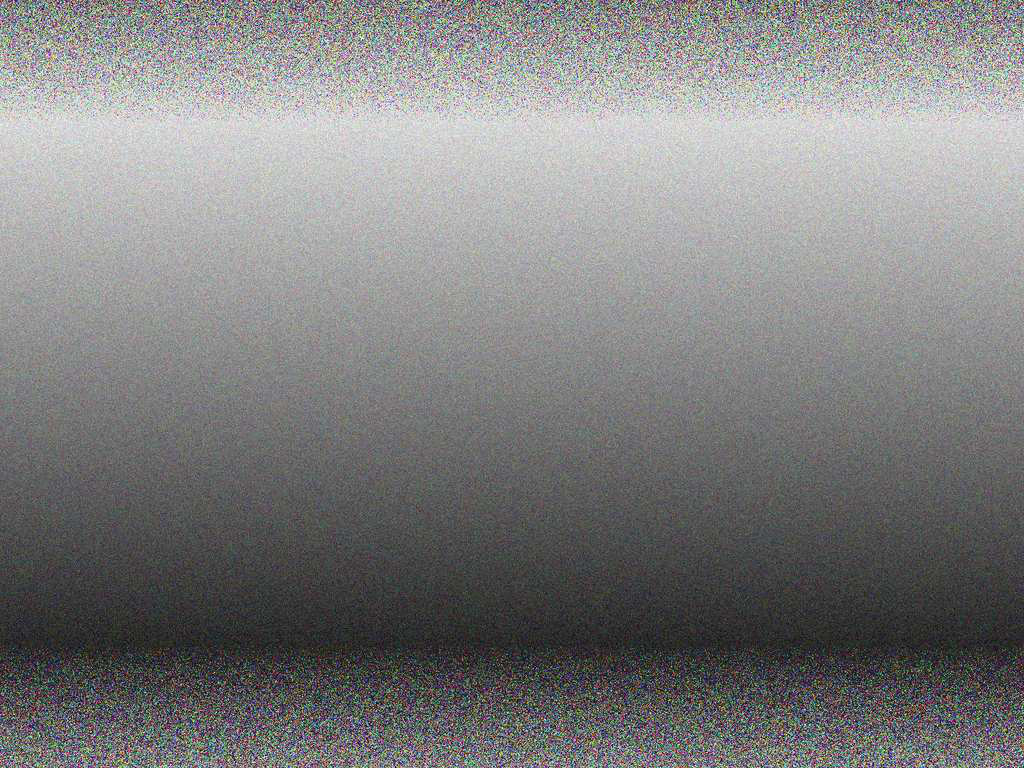

In [69]:
Image.open(test_img)

In [32]:
s = 'fdfsdfasf_[df]rtwe'

In [33]:
s[s.find('['): s.find(']') + 1]

'[df]'

In [37]:
modify_link(s)

'fdfsdfasf_df-Versionrtwe'